In [3]:
import torch
print("PyTorch version:", torch.__version__)
print("GPU available:", torch.cuda.is_available())

PyTorch version: 2.8.0+cu126
GPU available: True


In [24]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
train_dir = '/content/drive/My Drive/MalariaCellDetection/train_data'
test_dir = '/content/drive/My Drive/MalariaCellDetection/test_data'




print("Train folder contents:", os.listdir(train_dir))
print("Test folder contents:", os.listdir(test_dir))

Train folder contents: ['Parasite', 'Uninfected ']
Test folder contents: ['Parasite', 'Uninfected ']


In [5]:
from tensorflow import keras
print("Keras version:", keras.__version__)

Keras version: 3.10.0


In [ ]:
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = "/content/drive/MyDrive/Dataset/MalariaCellDetection/train_data"
test_dir  = "/content/drive/MyDrive/Dataset/MalariaCellDetection/test_data"

print("Train folder contents:", os.listdir(train_dir))
print("Test folder contents:", os.listdir(test_dir))

Train folder contents: ['Parasite', 'Uninfected ']
Test folder contents: ['Parasite', 'Uninfected ']


In [6]:
for folder in os.listdir(train_dir):
    path = os.path.join(train_dir, folder)
    print(f"Train/{folder} contains {len(os.listdir(path))} images")

for folder in os.listdir(test_dir):
    path = os.path.join(test_dir, folder)
    print(f"Test/{folder} contains {len(os.listdir(path))} images")

Train/Parasite contains 800 images
Train/Uninfected  contains 800 images
Test/Parasite contains 200 images
Test/Uninfected  contains 200 images


In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [8]:
# Training transforms (with augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),        # Resize images
    transforms.RandomHorizontalFlip(),    # Random flip
    transforms.RandomRotation(10),        # Small rotation
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize([0.5], [0.5])    # Normalize pixel values
])

# Testing transforms (no augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [9]:
# Load training dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)

# Load testing dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)

In [10]:
print("Number of training images:", len(train_dataset))
print("Number of testing images:", len(test_dataset))

Number of training images: 1600
Number of testing images: 400


In [11]:
batch_size = 32  # you can adjust depending on GPU

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Import models
from torchvision import models

# Load pretrained models
mobilenet = models.mobilenet_v2(pretrained=True)
densenet = models.densenet121(pretrained=True)
resnet = models.resnet50(pretrained=False)
vgg = models.vgg19(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 146MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 188MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:03<00:00, 159MB/s]


In [13]:
import torch.nn as nn

num_classes = 2

# MobileNet
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, num_classes)

# DenseNet
densenet.classifier = nn.Linear(densenet.classifier.in_features, num_classes)

# Resnet
resnet.fc = torch.nn.Linear(resnet.fc.in_features, 2)
# resnet.load_state_dict(torch.load("resnet_malaria.pth", map_location=device))

# Vgg
vgg.classifier[6] = torch.nn.Linear(vgg.classifier[6].in_features, 2)
# vgg.load_state_dict(torch.load("vgg_malaria.pth", map_location=device))

# Freeze VGG feature layers
for param in vgg.features.parameters():
    param.requires_grad = False


# Move models to device
mobilenet = mobilenet.to(device)
densenet = densenet.to(device)
resnet = resnet.to(device)
vgg = vgg.to(device)

In [14]:
criterion = nn.CrossEntropyLoss()

# You can use Adam optimizer
mobilenet_optimizer = torch.optim.Adam(mobilenet.parameters(), lr=0.001)
densenet_optimizer = torch.optim.Adam(densenet.parameters(), lr=0.001)
resnet_optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

# VGG Optimizer: Only optimize parameters that require gradients
vgg_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, vgg.parameters()), lr=0.001)

In [15]:
def train_model(model, optimizer, train_loader, test_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Debugging: Check VGG classifier gradients and weights
            if isinstance(model, models.VGG) and batch_idx == 0 and epoch == 0:
                print("VGG Classifier weights before step:", model.classifier[6].weight.sum())
                optimizer.step()
                print("VGG Classifier weights after step:", model.classifier[6].weight.sum())
            else:
                optimizer.step()


            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

        # Optional: evaluate on test set each epoch
        evaluate_model(model, test_loader)

In [16]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%\n")

In [17]:
# Example: Train MobileNet
train_model(mobilenet, mobilenet_optimizer, train_loader, test_loader, epochs=5)

# Example: Train DenseNet
train_model(densenet, densenet_optimizer, train_loader, test_loader, epochs=5)

Epoch [1/5], Loss: 0.2105, Accuracy: 93.56%
Test Accuracy: 95.75%

Epoch [2/5], Loss: 0.1254, Accuracy: 95.88%
Test Accuracy: 95.00%

Epoch [3/5], Loss: 0.1145, Accuracy: 96.31%
Test Accuracy: 95.50%

Epoch [4/5], Loss: 0.1025, Accuracy: 97.00%
Test Accuracy: 94.25%

Epoch [5/5], Loss: 0.1064, Accuracy: 96.38%
Test Accuracy: 95.25%

Epoch [1/5], Loss: 0.2166, Accuracy: 92.81%
Test Accuracy: 95.00%

Epoch [2/5], Loss: 0.1438, Accuracy: 95.44%
Test Accuracy: 95.00%

Epoch [3/5], Loss: 0.1196, Accuracy: 96.38%
Test Accuracy: 95.25%

Epoch [4/5], Loss: 0.1217, Accuracy: 96.25%
Test Accuracy: 95.00%

Epoch [5/5], Loss: 0.1214, Accuracy: 96.50%
Test Accuracy: 94.75%



In [18]:
# Train ResNet
train_model(resnet, resnet_optimizer, train_loader, test_loader, epochs=5)

Epoch [1/5], Loss: 0.7813, Accuracy: 57.06%
Test Accuracy: 59.50%

Epoch [2/5], Loss: 0.6119, Accuracy: 66.88%
Test Accuracy: 64.25%

Epoch [3/5], Loss: 0.2893, Accuracy: 88.81%
Test Accuracy: 94.25%

Epoch [4/5], Loss: 0.2859, Accuracy: 90.38%
Test Accuracy: 94.50%

Epoch [5/5], Loss: 0.1553, Accuracy: 95.50%
Test Accuracy: 93.50%



In [19]:
# Train VGG
train_model(vgg, vgg_optimizer, train_loader, test_loader, epochs=5)

VGG Classifier weights before step: tensor(0.2960, device='cuda:0', grad_fn=<SumBackward0>)
VGG Classifier weights after step: tensor(0.2960, device='cuda:0', grad_fn=<SumBackward0>)
Epoch [1/5], Loss: 0.8943, Accuracy: 69.50%
Test Accuracy: 90.50%

Epoch [2/5], Loss: 0.3212, Accuracy: 88.44%
Test Accuracy: 91.25%

Epoch [3/5], Loss: 0.2431, Accuracy: 92.06%
Test Accuracy: 92.00%

Epoch [4/5], Loss: 0.2212, Accuracy: 92.12%
Test Accuracy: 91.75%

Epoch [5/5], Loss: 0.3484, Accuracy: 89.62%
Test Accuracy: 90.25%



In [20]:
torch.save(mobilenet.state_dict(), "mobilenet_malaria.pth")
torch.save(densenet.state_dict(), "densenet_malaria.pth")
torch.save(resnet.state_dict(), "resnet_malaria.pth")
torch.save(vgg.state_dict(), "vgg_malaria.pth")

In [21]:
def evaluate_model_confusion(model, test_loader, classes=['Parasitized', 'Uninfected']):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

In [30]:
# DenseNet
densenet = models.densenet121(pretrained=False)
densenet.classifier = torch.nn.Linear(densenet.classifier.in_features, 2)
densenet.load_state_dict(torch.load("densenet_malaria.pth", map_location=device))
densenet = densenet.to(device)

# MobileNet
mobilenet = models.mobilenet_v2(pretrained=False)
mobilenet.classifier[1] = torch.nn.Linear(mobilenet.last_channel, 2)
mobilenet.load_state_dict(torch.load("mobilenet_malaria.pth", map_location=device))
mobilenet = mobilenet.to(device)

# ResNet
resnet = models.resnet18(pretrained=False)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, 2)
resnet.load_state_dict(torch.load("resnet_malaria.pth", map_location=device))
resnet = resnet.to(device)

# ===== Load VGG =====
vgg = models.vgg19(pretrained=False)
vgg.classifier[6] = torch.nn.Linear(vgg.classifier[6].in_features, 2)
vgg.load_state_dict(torch.load("vgg_malaria.pth", map_location=device))  # <-- MISSING LINE
vgg = vgg.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


===== DenseNet Evaluation =====
Confusion Matrix:
[[181  19]
 [  2 198]]


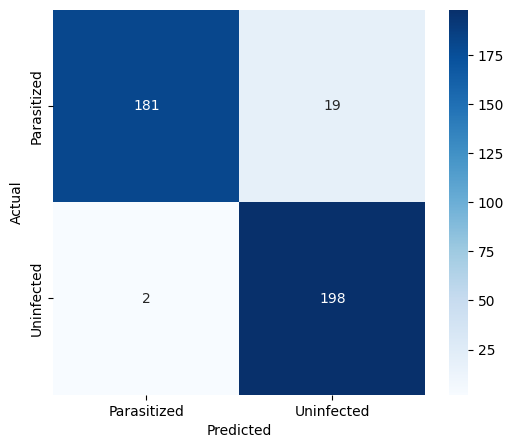

Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.99      0.91      0.95       200
  Uninfected       0.91      0.99      0.95       200

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400

===== MobileNet Evaluation =====
Confusion Matrix:
[[184  16]
 [  3 197]]


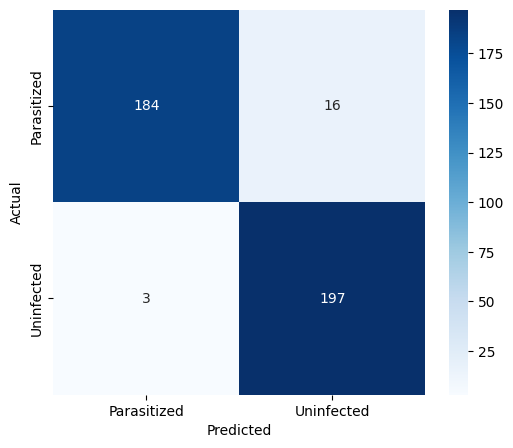

Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.98      0.92      0.95       200
  Uninfected       0.92      0.98      0.95       200

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400

===== ResNet Evaluation =====
Confusion Matrix:
[[176  24]
 [  2 198]]


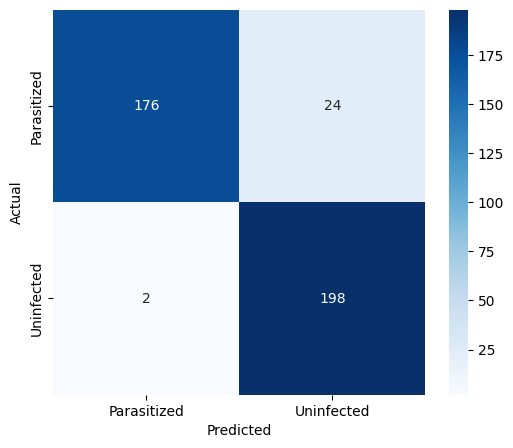

Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.99      0.88      0.93       200
  Uninfected       0.89      0.99      0.94       200

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.93       400
weighted avg       0.94      0.94      0.93       400

===== VGG Evaluation =====
Confusion Matrix:
[[191   9]
 [ 30 170]]


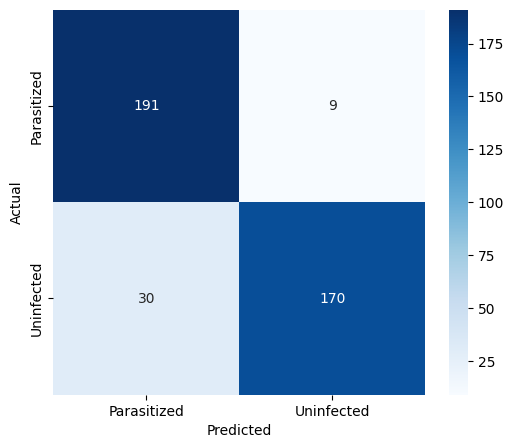

Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.86      0.95      0.91       200
  Uninfected       0.95      0.85      0.90       200

    accuracy                           0.90       400
   macro avg       0.91      0.90      0.90       400
weighted avg       0.91      0.90      0.90       400



In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

print("===== DenseNet Evaluation =====")
evaluate_model_confusion(densenet, test_loader)

print("===== MobileNet Evaluation =====")
evaluate_model_confusion(mobilenet, test_loader)

print("===== ResNet Evaluation =====")
evaluate_model_confusion(resnet, test_loader)

print("===== VGG Evaluation =====")
evaluate_model_confusion(vgg, test_loader)

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

def get_model_metrics(model, test_loader, classes=['Parasitized', 'Uninfected']):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    metrics = {
        "Accuracy": accuracy_score(all_labels, all_preds),
        "Precision": precision_score(all_labels, all_preds, average='weighted'),
        "Recall": recall_score(all_labels, all_preds, average='weighted'),
        "F1-Score": f1_score(all_labels, all_preds, average='weighted')
    }
    return metrics

In [33]:
densenet_metrics = get_model_metrics(densenet, test_loader)
mobilenet_metrics = get_model_metrics(mobilenet, test_loader)

In [34]:
resnet_metrics = get_model_metrics(resnet, test_loader)
vgg_metrics = get_model_metrics(vgg, test_loader)

df_metrics = pd.DataFrame([densenet_metrics, mobilenet_metrics, resnet_metrics, vgg_metrics], index=['DenseNet', 'MobileNet', 'ResNet', 'VGG'])
print(df_metrics)

           Accuracy  Precision  Recall  F1-Score
DenseNet     0.9475   0.950757  0.9475  0.947405
MobileNet    0.9525   0.954420  0.9525  0.952450
ResNet       0.9350   0.940328  0.9350  0.934803
VGG          0.9025   0.906987  0.9025  0.902231


In [ ]:
from PIL import Image
import torch
from torchvision import transforms, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model (example: DenseNet)
densenet = models.densenet121(pretrained=False)
densenet.classifier = torch.nn.Linear(densenet.classifier.in_features, 2)
densenet.load_state_dict(torch.load("densenet_malaria.pth", map_location=device))
densenet = densenet.to(device)
densenet.eval()

# Preprocessing
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def predict_image(model, image_path):
    image = Image.open(image_path).convert("RGB")
    image = preprocess(image).unsqueeze(0).to(device)  # add batch dimension
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)
    classes = ['Parasitized', 'Uninfected']
    return classes[pred.item()]

image_path = "/content/drive/MyDrive/Dataset/MalariaCellDetection/test_data/Parasite/C46P7ThinF_IMG_20151130_205828_cell_144.png"
print("Predicted class:", predict_image(densenet, image_path))

Predicted class: Parasitized
